In [315]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' %x)
%matplotlib inline

## Regression models

This notebook is intended to be an eternal exploration of the particularities of regression models

### 1) Load data

In [2]:
vg_df = pd.read_csv('./VG_Sales.csv')
vg_df = vg_df.drop('Year_of_Release', axis=1)
vg_df.head()

,Name,Platform,Publisher,Developer,Genre,Rating,Critic_Score,Critic_Count,User_Score,User_Count,Global_Sales
0,Wii Sports,Wii,Nintendo,Nintendo,Sports,E,76.0,51.0,8,322.0,82.53
1,Super Mario Bros.,NES,Nintendo,NaN,Platform,NaN,NaN,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,Nintendo,Nintendo,Racing,E,82.0,73.0,8.3,709.0,35.52
3,Wii Sports Resort,Wii,Nintendo,Nintendo,Sports,E,80.0,73.0,8,192.0,32.77
4,Pokemon Red/Pokemon Blue,GB,Nintendo,NaN,Role-Playing,NaN,NaN,NaN,NaN,NaN,31.37


### 2) Explore data

In [ ]:
vg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Publisher     16665 non-null  object 
 3   Developer     10096 non-null  object 
 4   Genre         16717 non-null  object 
 5   Rating        9950 non-null   object 
 6   Critic_Score  8137 non-null   float64
 7   Critic_Count  8137 non-null   float64
 8   User_Score    10015 non-null  object 
 9   User_Count    7590 non-null   float64
 10  Global_Sales  16719 non-null  float64
dtypes: float64(4), object(7)
memory usage: 1.4+ MB


In [ ]:
# User_Score as object indicates presence of non-numerical values
vg_df['User_Score'].value_counts()

tbd    2425
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.9       2
2.3       2
1.1       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

In [3]:
# Substitute 'tbd' for NaN values
vg_df['User_Score'].replace(to_replace='tbd', value=None, inplace=True)
# Convert column to float dtype
vg_df['User_Score'] = vg_df['User_Score'].astype(float)
vg_df.describe()

,Critic_Score,Critic_Count,User_Score,User_Count,Global_Sales
count,8137.000000,8137.000000,8760.000000,7590.000000,16719.000000
mean,68.967679,26.360821,7.099749,162.229908,0.533543
std,13.938165,18.980495,1.520065,561.282326,1.547935
min,13.000000,3.000000,0.000000,4.000000,0.010000
25%,60.000000,12.000000,6.400000,10.000000,0.060000
50%,71.000000,21.000000,7.500000,24.000000,0.170000
75%,79.000000,36.000000,8.200000,81.000000,0.470000
max,98.000000,113.000000,9.700000,10665.000000,82.530000


#### Histograms

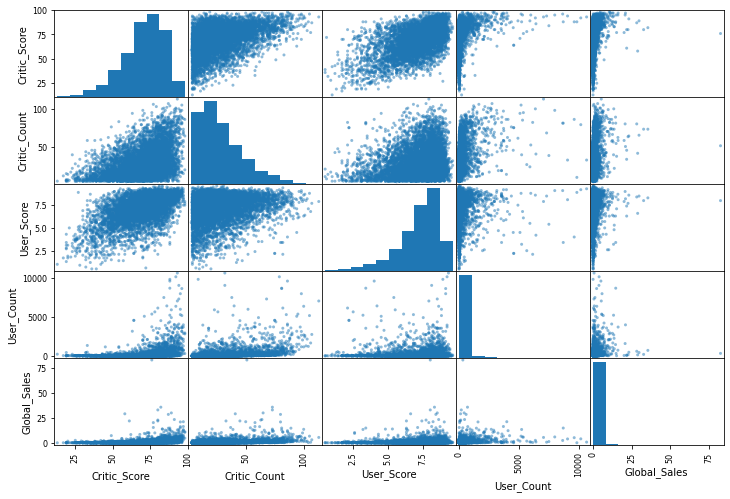

In [188]:
numerical_cols = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']
scatter_matrix(vg_df[numerical_cols], figsize=(12,8))
plt.show()

Describe() results and histograms analysis:
- Critic_Count, User_Count and Global_Sales have tail-heavy distributions, that is, they extend much farther to the right of the median than to the left. Thefore, we will need to transform them to have more bell-shaped distributions and make it easier for our algorithms to detect patterns
- Since Critic_Score and User_Score have more 'normal-like' distributions, we will only scale them

#### Correlations

In [ ]:
# Correlations
correlation_matrix = vg_df.corr()
correlation_matrix['Global_Sales'].sort_values(ascending=False)

Global_Sales    1.000000
Critic_Count    0.303571
User_Count      0.265012
Critic_Score    0.245471
User_Score      0.087558
Name: Global_Sales, dtype: float64

In [ ]:
correlation_matrix['Critic_Score'].sort_values(ascending=False)

Critic_Score    1.000000
User_Score      0.541718
Critic_Count    0.425504
User_Count      0.264376
Global_Sales    0.245471
Name: Critic_Score, dtype: float64

In [ ]:
correlation_matrix['User_Score'].sort_values(ascending=False)

User_Score      1.000000
Critic_Score    0.541718
Critic_Count    0.194028
Global_Sales    0.087558
User_Count      0.027044
Name: User_Score, dtype: float64

Correlations analysis:
- Independent variables don't have particularly strong linear relationships with the dependent variable > correlations around and below 0.30
- Also, we have no multicollinearity issues (strong linear relationship betwen two independent variable), since no correlations are higher than 0.7 (rule of thumb generally used)

#### Drop missing values and categorical columns

Developer and Publisher columns have too much value variability and no easy way for aggregating these values. Because of that, we will drop these columns

In [ ]:
vg_df['Developer'].value_counts()

Ubisoft                        204
EA Sports                      172
EA Canada                      167
Konami                         162
Capcom                         139
                              ... 
WildTangent                      1
Sunrise Interactive              1
Realtime Worlds                  1
Triple Eh? Ltd                   1
Game Arts, Seta Corporation      1
Name: Developer, Length: 1696, dtype: int64

In [ ]:
vg_df['Publisher'].value_counts()

Electronic Arts                 1356
Activision                       985
Namco Bandai Games               939
Ubisoft                          933
Konami Digital Entertainment     834
                                ... 
Game Arts                          1
Fortyfive                          1
Takuyo                             1
SPS                                1
Ongakukan                          1
Name: Publisher, Length: 581, dtype: int64

In [4]:
vg_df = vg_df.drop(['Developer','Publisher'], axis=1)

Critic_Count and User_Count have more than 50% of their values missing. But they are the numerical features with higher correlation with our labels (Global_Sales): 0.30 and 0.27, respectively. Because of this, we will drop rows with missing values

In [ ]:
critic_count_p_missing = round(vg_df['Critic_Count'].isna().sum()/len(vg_df)*100, 2)
user_count_p_missing = round(vg_df['User_Count'].isna().sum()/len(vg_df)*100, 2)
print('Critic_Count, % missing: {}%'.format(critic_count_p_missing))
print('User_Count, % missing: {}%'.format(user_count_p_missing))

Critic_Count, % missing: 51.33%
User_Count, % missing: 54.6%


In [5]:
vg_df.dropna(subset=['Critic_Count'], axis=0, how='any', inplace=True)
vg_df.dropna(subset=['User_Count'], axis=0, how='any', inplace=True)

#### Categories removal

Remove platforms, genres and ratings with less than 100 games, in order to restrict number of categorical features

In [ ]:
vg_df['Platform'].value_counts()

PS2     1161
X360     881
PS3      790
PC       703
XB       581
Wii      492
DS       469
PSP      393
GC       356
PS4      249
GBA      241
XOne     165
3DS      158
PS       156
PSV      119
WiiU      89
DC        14
Name: Platform, dtype: int64

In [6]:
# Remove bottom 2
plat_removal_list = list(vg_df['Platform'].value_counts()[vg_df['Platform'].value_counts() < 100].index)
plat_keep_list = [plat for plat in pd.unique(vg_df['Platform']) if plat not in plat_removal_list]
vg_df = vg_df[vg_df['Platform'].isin(plat_keep_list)].copy()

In [ ]:
vg_df['Genre'].value_counts()

Action          1638
Sports           966
Shooter          880
Role-Playing     715
Racing           595
Platform         391
Misc             384
Fighting         378
Simulation       304
Strategy         283
Adventure        262
Puzzle           118
Name: Genre, dtype: int64

In [ ]:
# No removal

In [ ]:
vg_df['Rating'].value_counts()

T       2400
E       2086
M       1444
E10+     910
RP         2
AO         1
K-A        1
Name: Rating, dtype: int64

In [7]:
# Remove bottom 3
rating_removal_list = list(vg_df['Rating'].value_counts()[vg_df['Rating'].value_counts() < 100].index)
rating_keep_list = [rating for rating in pd.unique(vg_df['Rating']) if rating not in rating_removal_list]
vg_df = vg_df[vg_df['Rating'].isin(rating_keep_list)].copy()
vg_df = vg_df.reset_index(drop=True)

### 3) Preprocessing

#### Split data    

In [275]:
Y = vg_df['Global_Sales'].copy()
features_df = vg_df.drop(['Name', 'Global_Sales'], axis=1).copy()
X_train, X_test, Y_train, Y_test = train_test_split(features_df, Y, test_size=0.2, shuffle=True, random_state=0)
max_Y_train = max(Y_train)
X_train.shape, X_test.shape

((5528, 7), (1382, 7))

In [276]:
num_transform_cols = ['Critic_Count', 'User_Count']
num_scale_cols = ['Critic_Score', 'User_Score']
cat_cols = ['Platform', 'Genre', 'Rating']

#### Define and run transformation (feature engineering) pipelines

In [277]:
# Transform tail-heavy variables with Box-Cox
# Box-Cox definition
# y = (x**lmbda - 1) / lmbda,  for lmbda > 0
#     log(x),                  for lmbda = 0
# Transformer maximizes the log-likelihood function, that is, searches for optimal value of lmbda
# Here, optimal means the value that brings input distribution closer to a Gaussian distribution
# Also, if standardize=True, distribution is normalized to have zero-mean and unit-variance
num_transform_pipeline = Pipeline([
        ('box-cox', PowerTransformer(method='box-cox', standardize=True))
])

# Zero-mean, unit-variance normalization   
num_scale_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
])

# Impute mode (most frequent)   
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder())
])

# If sparse_threshold != 0, returns sparse matrix if overall density (%) is lower than this value
full_pipeline = ColumnTransformer([
        ('num_transform', num_transform_pipeline, num_transform_cols),
        ('num_scale', num_scale_pipeline, num_scale_cols),
        ('cat', cat_pipeline, cat_cols)
], sparse_threshold=0)

In [278]:
X_train_final = full_pipeline.fit_transform(X_train)
X_test_final = full_pipeline.transform(X_test)

##### Visualize features

In [279]:
pd.DataFrame(X_train_final)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.050041,1.069415,0.202917,0.361973,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.335614,0.439543,1.071124,1.192143,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.200571,-0.550540,-0.158836,1.053782,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.481884,-1.364248,-1.678198,0.777058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.497643,0.238282,0.637020,0.915420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5523,-0.200571,0.516876,0.926422,0.085250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5524,0.042683,-0.854269,0.854072,0.431154,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5525,1.312364,1.022822,0.130566,0.016069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5526,-2.064278,-0.765762,-0.014135,1.053782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


- Feature order: Critic_Count, User_Count, Critic_Score, User_Score, Platform (4-18), Genre (19-30), Rating (31-34)
- Categorical features sorted by alphabetical order, that is, 4 = 3DS, 19 = Action and 31 = E

#### Transform labels with Box-Cox power transformation as well (it was also a tail-heavy distribution)

In [280]:
Y_transform = PowerTransformer(method='box-cox', standardize=True)
Y_train_final = Y_transform.fit_transform(Y_train.to_numpy().reshape(-1,1))
Y_test_final = Y_transform.transform(Y_test.to_numpy().reshape(-1,1))

#### Histogram comparisons (before and after power transformation)

##### User_Count

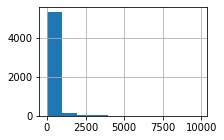

In [253]:
# BEFORE
X_train['User_Count'].hist(figsize=(3,2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0831255160>]],
      dtype=object)

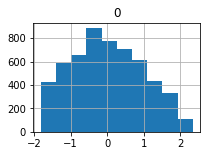

In [254]:
# AFTER
uc_transformed = PowerTransformer(method='box-cox', standardize=True).fit_transform(X_train['User_Count'].to_numpy().reshape(-1,1))
pd.DataFrame(uc_transformed).hist(figsize=(3,2))

##### Critic_Count

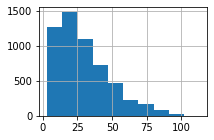

In [255]:
# BEFORE
X_train['Critic_Count'].hist(figsize=(3,2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f083120b080>]],
      dtype=object)

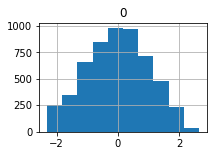

In [256]:
# AFTER
cc_transformed = PowerTransformer(method='box-cox', standardize=True).fit_transform(X_train['Critic_Count'].to_numpy().reshape(-1,1))
pd.DataFrame(cc_transformed).hist(figsize=(3,2))

##### Labels

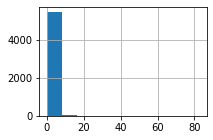

In [260]:
# BEFORE
Y_train.hist(figsize=(3,2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f083120b978>]],
      dtype=object)

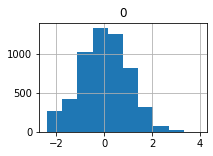

In [257]:
# AFTER
pd.DataFrame(Y_train_final).hist(figsize=(3,2))

### 4) Train and compare models

#### Define baseline: median of train labels

In [311]:
baseline_dict = {}
baseline_dict['model_type'] = 'median_train'
baseline_dict['name'] = 'baseline'

median_train = np.median(Y_train_final)
Y_train_pred = np.full(X_train.shape[0], median_train).reshape(-1,1)
baseline_dict['train_rmse'] = mean_squared_error(Y_train_final, Y_train_pred, squared=False)
Y_test_pred = np.full(X_test.shape[0], median_train).reshape(-1,1)
baseline_dict['test_rmse'] = mean_squared_error(Y_test_final, Y_test_pred, squared=False)
baseline_dict['pred_'+str(max_Y_train)] = max(Y_transform.inverse_transform(np.asarray([median_train]).reshape(-1,1)))[0]

#### Train and evaluate

In [298]:
def define_model(m_type, name, degree=None, hidden_layer_sizes=None, alpha=None):
    m = dict()
    m['m_type'] = m_type 
    m['name'] = name
    m['degree'] = degree
    m['hidden_layer_sizes'] = hidden_layer_sizes
    m['alpha'] = alpha
    return m

def train_evaluate_model(m_type, name, degree, hidden_layer_sizes, alpha):    
    models = {
        'lin_reg': LinearRegression(),
        # Lasso: L1 regularization
        'lasso': Lasso(),
        # Ridge: L2 regularization
        'ridge': Ridge(),
        'knn': KNeighborsRegressor(),
        'poly_reg': make_pipeline(PolynomialFeatures(degree=degree), LinearRegression()),
        'nn': MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', alpha=alpha, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005, \
                           max_iter=100, verbose=False, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    }  
    
    model = models.get(m_type, '')
    model.fit(X_train_final, Y_train_final)
    
    # Predictions
    Y_train_pred = model.predict(X_train_final)
    Y_test_pred = model.predict(X_test_final)

    evaluation_dict = dict()
    evaluation_dict['model_type'] = m_type
    if m_type == 'poly_reg':
        evaluation_dict['name'] = name+'_'+str(degree)
    else:
        evaluation_dict['name'] = name
    evaluation_dict['train_rmse'] = mean_squared_error(Y_train_final, Y_train_pred, squared=False)
    evaluation_dict['test_rmse'] = mean_squared_error(Y_test_final, Y_test_pred, squared=False)
    evaluation_dict['pred_'+str(max_Y_train)] = max(Y_transform.inverse_transform(Y_train_pred.reshape(-1,1)))[0]
    return model, evaluation_dict

def compare_models(eval_dict_list):
    eval_dict_list.insert(0, baseline_dict)
    df = pd.DataFrame(eval_dict_list)
    
    # idxmax: returns index of row with max column value
    m_min_train_rmse = df.iloc[df['train_rmse'].idxmin()]['name']
    m_min_test_rmse = df.iloc[df['test_rmse'].idxmin()]['name']
    
    print('Minimum Train RMSE: {}\nMinimum Test RMSE: {}\n'.format(m_min_train_rmse, m_min_test_rmse))
    return df

In [296]:
lin_reg_dict = define_model(m_type='lin_reg', name='lin_reg')
lasso_dict = define_model(m_type='lasso', name='lasso')
ridge_dict = define_model(m_type='ridge', name='ridge')
knn_dict = define_model(m_type='knn', name='knn')
poly_reg_dict = define_model(m_type='poly_reg', name='poly_reg', degree=2)

# NN
# Default value for alpha
nn_10_dict = define_model(m_type='nn', name='nn_10', hidden_layer_sizes=(10,), alpha=0.0001)
nn_100_dict = define_model(m_type='nn', name='nn_100', hidden_layer_sizes=(100,), alpha=0.0001)
# Optimal, according to Random Search (ran below)
nn_opt_dict = define_model(m_type='nn', name='nn_opt', hidden_layer_sizes=(100,100,100), alpha=1.3631330640994466)

In [314]:
model_spec_list = [lin_reg_dict, lasso_dict, ridge_dict, knn_dict, poly_reg_dict, nn_10_dict, nn_100_dict, nn_opt_dict]

model_list = []
eval_dict_list = []

for m in model_spec_list:
    model, evaluation_dict = train_evaluate_model(m['m_type'], m['name'], m['degree'], m['hidden_layer_sizes'], m['alpha'])
    model_list.append(model)
    eval_dict_list.append(evaluation_dict)

eval_df = compare_models(eval_dict_list)
eval_df


Minimum Train RMSE: nn_100
Minimum Test RMSE: nn_opt



,model_type,name,train_rmse,test_rmse,pred_82.53
0,median_train,baseline,1.0000,1.0268,0.2900
1,lin_reg,lin_reg,0.6870,0.7097,6.9172
2,lasso,lasso,1.0000,1.0267,0.2877
3,ridge,ridge,0.6870,0.7096,6.8533
4,knn,knn,0.5861,0.7254,9.5656
5,poly_reg,poly_reg_2,0.6103,88200964.7084,19.3288
6,nn,nn_10,0.6134,0.6777,15.1747
7,nn,nn_100,0.4794,0.7179,43.6744
8,nn,nn_opt,0.6206,0.6538,8.8727


All columns are self-explanatory, except the last one, which is the prediction for the maximum Y training value

Table analysis:
- nn_100 has a reasonable difference between train and test errors, which indicates overfitting (high variance). The default alpha value used is too small, so this result was expected
- On the other hand, with less regularization, this NN does a better job at identifying best-sellers than the optimal NN discovered via Random Search
- I also tested the polynomial regression with higher degrees. Similarly to the result for the model with 2, the values for the test RMSE were enormous, indicating very bad cases of overfitting (high variance)


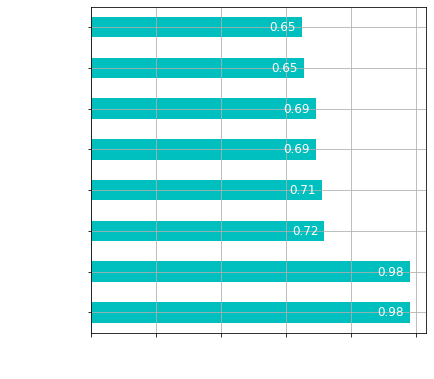

In [264]:
# Plotting test errors (without polynomial)
test_error_df = eval_df.loc[:,['name','test_rmse']].copy()
test_error_df.drop(test_error_df.loc[test_error_df['name']=='poly_reg_2'].index, inplace=True)
test_error_df = test_error_df.sort_values('test_rmse', ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)

test_error_df.plot(x='name', y='test_rmse', kind='barh', color='c', legend=False, figsize=(6,6), grid=True, ax=ax)
plt.yticks(size=14, color='w')
plt.xticks(size=14, color='w')
plt.ylabel("Models", size=14, color='w')
plt.xlabel("Test RMSE", size=14, color='w')
for i, v in enumerate(sorted(test_error_df['test_rmse'], reverse=True)):
    plt.text(v-0.1, i, str(round(v,2)), color='w', va='center', size=12)
plt.show()

#### Optimize NN

We could optimize for many hyperparameters for all models used: alpha for Lasso and Ridge, nummber of neighbors for KNN, degree for Polynomial and many more. But I decided to only use a quick Random Search for some crucial parameters of the NN, to check if it can quickly move away (towards better performance) from the other models

In [110]:
params = [
    {'hidden_layer_sizes': [(10,), (50,), (100,), \
                            (10,10), (50,50), (100,100), \
                            (10,10,10), (50,50,50), (100,100,100), \
                            (10,10,10,10), (50,50,50,50), (100,100,100,100), \
                            (10,10,10,10,10), (50,50,50,50,50), (100,100,100,100,100)], \
     'alpha': uniform(0.01,10)}
]

nn_model = MLPRegressor(activation='relu', solver='adam', batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005, \
                        max_iter=100, verbose=False, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

random_search = RandomizedSearchCV(nn_model, params, n_iter=500, scoring='neg_root_mean_squared_error', cv=2, return_train_score=True, n_jobs=-1, verbose=10)

In [111]:
random_search.fit(X_train_final, Y_train_final)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='adaptive',
                                          learning_rate_init=0.005,
                                          max_fun=15000, max_iter=100,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_...
                   param_distributions=[{'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f083fa03208>,
                                         'hidden_layer_sizes': [(10

In [112]:
# Check best params and corresponding score
print(random_search.best_params_, min(-random_search_results['mean_test_score']))

{'alpha': 1.3631330640994466, 'hidden_layer_sizes': (100, 100, 100)} 0.6484048423953312


### 5) Next steps

#### Different features

- Weighted score
- Different encodings for categorical variables

#### Feature importance

- Explore which features are the most relevant for some models

#### Residual analysis

Assumptions: 
- Constant variance of error terms
- Uncorrelated error terms